In [1]:
from __future__ import print_function, division

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [3]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar

Using TensorFlow backend.


In [4]:
print(keras.__version__, tf.__version__)

2.3.1 1.13.1


In [5]:
from models import QATM, MyNormLayer
from utils import compute_score, locate_bbox

## Load data

In [6]:
file_dir = 'data'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if '.jpg' in i ] )
def read_gt( file_path ):
    with open( file_path ) as IN:
        x, y, w, h = [ eval(i) for i in IN.readline().strip().split(',')]
    return x, y, w, h

## utils

In [7]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 3), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )
    T_feat = featex(T)
    I_feat = featex(I)
    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')( dist )
    return Model( [T, I], [conf_map], name='QATM_model' )
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    num_samples = len(img_path) // 2
    bar = progressbar.ProgressBar(max_value=num_samples)
    for idx in range(num_samples):
        bar.update(idx + 1)
        # load image and ground truth
        template_raw = cv2.imread( img_path[2*idx] )[...,::-1]
        template_bbox = read_gt( gt[2*idx] )
        x, y, w, h = [int(round(t)) for t in template_bbox]
        template = template_raw[y:y+h, x:x+w]
        image = cv2.imread( img_path[2*idx+1] )[...,::-1]
        image_gt = read_gt( gt[2*idx+1] )
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        
        # process images
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)
        if w*h <= 4000:
            val = model.predict( [template_, image_] )
        else:
            # used when image is too big
            val = model_bkup.predict( [template_, image_] )
        
        # compute geometry mean on score map
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        score = compute_score( gray, w_gt, h_gt )
        score[score>-1e-7] = -np.inf
        
        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

## Start testing

In [8]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

In [10]:
model = create_model( featex , alpha=25)
model_bkup = create_model( featex2 , alpha=25)

In [11]:
def run_one_sample( idx=0 ):
    '''
    idx: index of image in OTB dataset, from 0 to 104
    '''
    # load image and ground truth
    template_raw = cv2.imread( img_path[2*idx] )[...,::-1]
    template_bbox = read_gt( gt[2*idx] )
    x, y, w, h = [int(round(t)) for t in template_bbox]
    template_plot = cv2.rectangle( template_raw.copy(), (x, y), (x+w, y+h), (0, 255,0), 2 )
    template = template_raw[y:y+h, x:x+w]
    image = cv2.imread( img_path[2*idx+1] )[...,::-1]
    image_gt = read_gt( gt[2*idx+1] )
    x, y, w, h = [int(round(t)) for t in image_gt]
    image_plot = cv2.rectangle( image.copy(), (x, y), (x+w, y+h), (0, 255, 0), 2 )

    # process images
    template_ = np.expand_dims(preprocess_input( template ), axis=0)
    image_ = np.expand_dims(preprocess_input( image ) , axis=0)
    if w*h <= 4000:
        val = model.predict( [template_, image_] )
    else:
        # used when image is too big
        val = model_bkup.predict( [template_, image_] )

    # compute geometry average on score map
    val = np.log( val )
    gray = val[0,:,:,0]
    gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
    score = compute_score( gray, w, h ) 
    score[score>-1e-7] = score.min()
    score = np.exp(score / (h*w)) # reverse number range back after computing geometry average
    
    # plot result
    x, y, w, h = locate_bbox( score, w, h )
    image_plot = cv2.rectangle( image_plot, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2 )
    fig, ax = plt.subplots( 1, 3, figsize=(20, 5) )
    ax[0].imshow(template_plot)
    ax[1].imshow(image_plot)
    
    ax[2].imshow(score, 'jet')
    plt.show()

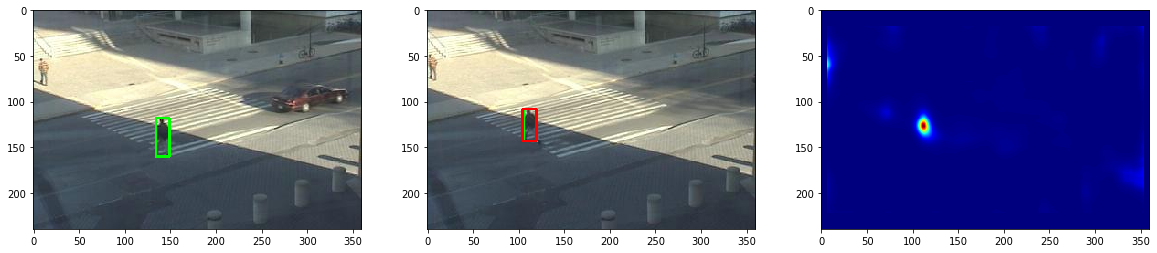

In [12]:
run_one_sample(15) # green: ground truth, red: prediction